In [6]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.transforms import InterpolationMode

class CustomOxfordPets(OxfordIIITPet):
    def __init__(self, *args, label_map=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.label_map = label_map

    def __getitem__(self, index):
        image, target = super().__getitem__(index)
        if self.label_map:
            target = self.label_map.get(target, target)
        return image, target

class LoadData:
    def __init__(self, binary=True, augment=False):
        self.transform = self._get_transforms(augment)
        self.classes = 2 if binary else 37
        self.dataset_trainval = self._load_dataset(split='trainval')
        self.test_dataset = self._load_dataset(split='test')

    def _get_transforms(self, augment):
        base_transform = [
            transforms.Resize(224, interpolation=InterpolationMode.BICUBIC),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]
        if augment:
            augment_transform = [
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10)
            ]
            base_transform[1:1] = augment_transform  # Insert augmentations after Resize
        return transforms.Compose(base_transform)

    def _load_dataset(self, split):
        return CustomOxfordPets(
            root='./data', transform=self.transform, download=True, split=split
        )

    def data_loaders(self, batch_size, split_ratio, labeled_percent=1):
        train_size = int(split_ratio * len(self.dataset_trainval))
        val_size = len(self.dataset_trainval) - train_size
        train_dataset, val_dataset = random_split(self.dataset_trainval, [train_size, val_size])
        return {
            'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
            'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False),
            'test': DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False)
        }

class Train:
    def __init__(self, data, layer_lr, bs, epochs, split_ratio, labeled_percent=1, model_path=None, unfreeze_layers=None):
        self.epochs = epochs
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.data = data
        self.loaders = self.data.data_loaders(bs, split_ratio, labeled_percent)
        self.model = self._initialize_model(model_path, num_classes=self.data.classes, unfreeze_layers=unfreeze_layers or [])
        self.loss_func = nn.CrossEntropyLoss()
        self.optimizer = self._create_optimizer(layer_lr)
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.1)
        self.training_losses = []
        self.validation_losses = []
        self.validation_accuracies = []

    def _initialize_model(self, model_path, num_classes, unfreeze_layers):
        model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1 if not model_path else None)
        for param in model.parameters():
            param.requires_grad = False
        if unfreeze_layers:
            for layer_name in unfreeze_layers:
                for param in getattr(model, layer_name).parameters():
                    param.requires_grad = True
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        if model_path:
            model.load_state_dict(torch.load(model_path))
        return model.to(self.device)


    def train(self):
        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0
            for images, labels in self.loaders['train']:
                images = images.to(self.device)
                labels = labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.loss_func(outputs, labels)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item() * images.size(0)
            train_loss /= len(self.loaders['train'].dataset)

            val_loss, val_accuracy = self.validate()
            self.training_losses.append(train_loss)
            self.validation_losses.append(val_loss)
            self.validation_accuracies.append(val_accuracy)
            self.scheduler.step()

            print(f'Epoch {epoch+1}/{self.epochs}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4%}')

    def validate(self):
        self.model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in self.loaders['val']:
                images = images.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(images)
                loss = self.loss_func(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss /= len(self.loaders['val'].dataset)
        val_accuracy = correct / total
        return val_loss, val_accuracy


    def _create_optimizer(self, layer_lr):
        param_groups = []
        for layer_name, lr in layer_lr.items():
            params = [param for param in getattr(self.model, layer_name).parameters() if param.requires_grad]
            param_groups.append({'params': params, 'lr': lr})
        return optim.Adam(param_groups)

def run_experiments():
    configurations = [
        (['fc'], 0.001),
        (['layer4', 'fc'], 0.0001),
        (['layer4', 'fc'], 0.00001)
    ]
    augmentation_settings = [True, False]
    results = {}
    
    for layers, lr in configurations:
        for augment in augmentation_settings:
            print(f"Running experiment with layers: {layers} and LR: {lr}, Augmentation: {augment}")
            data = LoadData(binary=False, augment=augment)
            trainer = Train(data, layer_lr={layer: lr for layer in layers}, bs=32, epochs=10, split_ratio=0.8, unfreeze_layers=layers)
            trainer.train()
            results[(str(layers), lr, augment)] = {
                'training_losses': trainer.training_losses,
                'validation_losses': trainer.validation_losses,
                'validation_accuracies': trainer.validation_accuracies
            }
    return results


# Run and print the results
experiment_results = run_experiments()
for config, outcomes in experiment_results.items():
    print(config, outcomes)


Running experiment with layers: ['fc'] and LR: 0.001, Augmentation: True
Epoch 1/10: Train Loss: 1.4064, Validation Loss: 0.5561, Validation Accuracy: 86.9565%
Epoch 2/10: Train Loss: 0.4470, Validation Loss: 0.4382, Validation Accuracy: 85.5978%
Epoch 3/10: Train Loss: 0.3195, Validation Loss: 0.3145, Validation Accuracy: 91.0326%
Epoch 4/10: Train Loss: 0.2633, Validation Loss: 0.3010, Validation Accuracy: 90.0815%
Epoch 5/10: Train Loss: 0.2279, Validation Loss: 0.2731, Validation Accuracy: 91.8478%
Epoch 6/10: Train Loss: 0.1670, Validation Loss: 0.2389, Validation Accuracy: 93.0707%
Epoch 7/10: Train Loss: 0.1568, Validation Loss: 0.2339, Validation Accuracy: 93.4783%
Epoch 8/10: Train Loss: 0.1521, Validation Loss: 0.2336, Validation Accuracy: 93.0707%
Epoch 9/10: Train Loss: 0.1495, Validation Loss: 0.2340, Validation Accuracy: 93.6141%
Epoch 10/10: Train Loss: 0.1517, Validation Loss: 0.2201, Validation Accuracy: 93.7500%
Running experiment with layers: ['fc'] and LR: 0.001, Au

In [1]:
import pickle

def save_results(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    print(f"Results saved to {filename}")

# 假设 experiment_results 是你的实验结果数据
filename = "experiment_results.pkl"
save_results(experiment_results, filename)


NameError: name 'experiment_results' is not defined

In [2]:
import matplotlib.pyplot as plt

def plot_validation_results(experiment_results):
    # 根据配置排序和分组结果
    sorted_keys = sorted(experiment_results.keys(), key=lambda x: (x[0], x[1], not x[2]))
    grouped_results = {}
    for config in sorted_keys:
        layer_lr_key = (config[0], config[1])
        if layer_lr_key not in grouped_results:
            grouped_results[layer_lr_key] = []
        grouped_results[layer_lr_key].append((config, experiment_results[config]))

    # 为每组配置创建一张图
    for layer_lr_key, data in grouped_results.items():
        plt.figure(figsize=(10, 5))
        ax1 = plt.gca()
        ax2 = ax1.twinx()

        colors = {'True': ('#00b359', '#ff3333'), 'False': ('#005c99', '#b30000')}
        for config, outcomes in data:
            augment_status = 'Augment' if config[2] else 'No Augument'
            color_acc, color_loss = colors[str(config[2])]

            ax1.plot(outcomes['validation_accuracies'], label=f'Accuracy - {augment_status}', color=color_acc)
            ax2.plot(outcomes['validation_losses'], label=f'Loss - {augment_status}', color=color_loss, linestyle='--')

        # Updated title without slashes
        title = f"LR: {layer_lr_key[1]}, Layers: {''.join(layer_lr_key[0])}"
        ax1.set_title(title)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy', color='#0066cc')
        ax2.set_ylabel('Loss', color='#cc3300')
        
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        
        plt.grid(True)
        plt.show()

# 假设 experiment_results 是你的实验结果数据
plot_validation_results(experiment_results)



NameError: name 'experiment_results' is not defined

In [8]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.transforms import InterpolationMode

class CustomOxfordPets(OxfordIIITPet):
    def __init__(self, *args, label_map=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.label_map = label_map

    def __getitem__(self, index):
        image, target = super().__getitem__(index)
        if self.label_map:
            target = self.label_map.get(target, target)
        return image, target

class LoadData:
    def __init__(self, binary=True, augment=True):
        self.transform = self._get_transforms(augment)
        self.classes = 2 if binary else 37
        self.dataset_trainval = self._load_dataset(split='trainval')
        self.test_dataset = self._load_dataset(split='test')

    def _get_transforms(self, augment):
        base_transform = [
            transforms.Resize(224, interpolation=InterpolationMode.BICUBIC),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]
        if augment:
            augment_transform = [
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10)
            ]
            base_transform[1:1] = augment_transform  # Insert augmentations after Resize
        return transforms.Compose(base_transform)

    def _load_dataset(self, split):
        return CustomOxfordPets(
            root='./data', transform=self.transform, download=True, split=split
        )

    def data_loaders(self, batch_size, split_ratio, labeled_percent=1.0):
        # 获取训练集和验证集
        train_size = int(split_ratio * len(self.dataset_trainval))
        val_size = len(self.dataset_trainval) - train_size
        train_dataset, val_dataset = random_split(self.dataset_trainval, [train_size, val_size])
        
        # 计算标注数据的数量
        labeled_size = int(labeled_percent * len(train_dataset))
        unlabeled_size = len(train_dataset) - labeled_size
        
        # 使用 `random_split` 将训练集分成标注数据和未标注数据
        labeled_dataset, _ = random_split(train_dataset, [labeled_size, unlabeled_size])
        
        return {
            'train': DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True),
            'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False),
            'test': DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False)
        }

class Train:
    def __init__(self, data, layer_lr, bs, epochs, split_ratio, labeled_percent=1, unfreeze_interval=5, model_path=None, unfreeze_layers=None):
        self.epochs = epochs
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.data = data
        self.loaders = self.data.data_loaders(bs, split_ratio, labeled_percent)
        self.model = self._initialize_model(model_path, num_classes=self.data.classes, unfreeze_layers=unfreeze_layers or [])
        self.loss_func = nn.CrossEntropyLoss()
        self.optimizer = self._create_optimizer(layer_lr)
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.1)
        self.unfreeze_interval = unfreeze_interval
        self.training_losses = []
        self.validation_losses = []
        self.validation_accuracies = []

    def _initialize_model(self, model_path, num_classes, unfreeze_layers):
        model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1 if not model_path else None)
        for param in model.parameters():
            param.requires_grad = False  # 初始冻结所有层
        if unfreeze_layers:
            for layer_name in unfreeze_layers:
                for param in getattr(model, layer_name).parameters():
                    param.requires_grad = True
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        if model_path:
            model.load_state_dict(torch.load(model_path))
        return model.to(self.device)

    # def _unfreeze_next_layer(self):
    #     """解冻下一个层"""
    #     if len(self.optimizer.param_groups) == 2:
    #         # 解冻 layer3
    #         for param in self.model.layer3.parameters():
    #             param.requires_grad = True
    #         self.optimizer.add_param_group({'params': self.model.layer3.parameters(), 'lr': self.optimizer.param_groups[0]['lr'] / 10})
    #         print("解冻 layer 3")

    #     elif len(self.optimizer.param_groups) == 3:
    #         # 解冻 layer2
    #         for param in self.model.layer2.parameters():
    #             param.requires_grad = True
    #         self.optimizer.add_param_group({'params': self.model.layer2.parameters(), 'lr': self.optimizer.param_groups[0]['lr'] / 100})
    #         print("解冻 layer 2")

    def train(self):
        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0
            for images, labels in self.loaders['train']:
                images = images.to(self.device)
                labels = labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.loss_func(outputs, labels)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item() * images.size(0)
            train_loss /= len(self.loaders['train'].dataset)

            val_loss, val_accuracy = self.validate()
            self.training_losses.append(train_loss)
            self.validation_losses.append(val_loss)
            self.validation_accuracies.append(val_accuracy)
            self.scheduler.step()

            # 每隔 unfreeze_interval 个 epoch 解冻一层
            if (epoch + 1) % self.unfreeze_interval == 0:
                self._unfreeze_next_layer()

            print(f'Epoch {epoch+1}/{self.epochs}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4%}')

    def validate(self):
        self.model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in self.loaders['val']:
                images = images.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(images)
                loss = self.loss_func(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss /= len(self.loaders['val'].dataset)
        val_accuracy = correct / total
        return val_loss, val_accuracy

    def _create_optimizer(self, layer_lr):
        param_groups = []
        for layer_name, lr in layer_lr.items():
            params = [param for param in getattr(self.model, layer_name).parameters() if param.requires_grad]
            param_groups.append({'params': params, 'lr': lr})
        return optim.Adam(param_groups)

def run_experiments():
    configurations = [
        (['fc'], 0.001),
        (['layer4', 'fc'], 0.0001)
    ]
    labeled_percents = [1.0, 0.5, 0.1, 0.01]  # 使用 100%、50%、10%、1% 标注数据
    results = {}
    
    for layers, lr in configurations:
        for labeled_percent in labeled_percents:
            print(f"Running experiment with layers: {layers}, LR: {lr}, Labeled Percent: {labeled_percent*100}%")
            data = LoadData(binary=False, augment=True)  # 始终使用数据增强
            trainer = Train(data, layer_lr={layer: lr for layer in layers}, bs=32, epochs=16, split_ratio=0.8, labeled_percent=labeled_percent, unfreeze_layers=layers)
            trainer.train()
            results[(str(layers), lr, labeled_percent)] = {
                'training_losses': trainer.training_losses,
                'validation_losses': trainer.validation_losses,
                'validation_accuracies': trainer.validation_accuracies
            }
    return results

# 运行实验并打印结果
experiment_results = run_experiments()
for config, outcomes in experiment_results.items():
    layers, lr, labeled_percent = config
    print(f"Layers: {layers}, Learning Rate: {lr}, Labeled Data: {labeled_percent*100}%")
    print("Training Losses:", outcomes['training_losses'])
    print("Validation Losses:", outcomes['validation_losses'])
    print("Validation Accuracies:", outcomes['validation_accuracies'])


Running experiment with layers: ['fc'], LR: 0.001, Labeled Percent: 100.0%
Epoch 1/10: Train Loss: 1.5255, Validation Loss: 0.5632, Validation Accuracy: 86.2772%
Epoch 2/10: Train Loss: 0.4693, Validation Loss: 0.3657, Validation Accuracy: 90.4891%
Epoch 3/10: Train Loss: 0.3336, Validation Loss: 0.3122, Validation Accuracy: 90.7609%
Epoch 4/10: Train Loss: 0.2613, Validation Loss: 0.3068, Validation Accuracy: 90.7609%
Epoch 5/10: Train Loss: 0.2350, Validation Loss: 0.2678, Validation Accuracy: 92.3913%
Epoch 6/10: Train Loss: 0.1671, Validation Loss: 0.2368, Validation Accuracy: 92.5272%
Epoch 7/10: Train Loss: 0.1644, Validation Loss: 0.2438, Validation Accuracy: 91.8478%
Epoch 8/10: Train Loss: 0.1616, Validation Loss: 0.2458, Validation Accuracy: 91.9837%
Epoch 9/10: Train Loss: 0.1522, Validation Loss: 0.2399, Validation Accuracy: 92.9348%
Epoch 10/10: Train Loss: 0.1585, Validation Loss: 0.2356, Validation Accuracy: 92.2554%
Running experiment with layers: ['fc'], LR: 0.001, Lab

In [6]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.transforms import InterpolationMode

class CustomOxfordPets(OxfordIIITPet):
    def __init__(self, *args, label_map=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.label_map = label_map

    def __getitem__(self, index):
        image, target = super().__getitem__(index)
        if self.label_map:
            target = self.label_map.get(target, target)
        return image, target

class LoadData:
    def __init__(self, binary=True, augment=False):
        self.transform = self._get_transforms(augment)
        self.classes = 2 if binary else 37
        self.dataset_trainval = self._load_dataset(split='trainval')
        self.test_dataset = self._load_dataset(split='test')

    def _get_transforms(self, augment):
        base_transform = [
            transforms.Resize(224, interpolation=InterpolationMode.BICUBIC),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]
        if augment:
            augment_transform = [
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10)
            ]
            base_transform[1:1] = augment_transform  # Insert augmentations after Resize
        return transforms.Compose(base_transform)

    def _load_dataset(self, split):
        return CustomOxfordPets(
            root='./data', transform=self.transform, download=True, split=split
        )

    def data_loaders(self, batch_size, split_ratio, labeled_percent=1):
        labeled_size = int(len(self.dataset_trainval) * labeled_percent)
        val_size = len(self.dataset_trainval) - labeled_size
        labeled_dataset, _ = random_split(self.dataset_trainval, [labeled_size, val_size])

        train_size = int(split_ratio * len(labeled_dataset))
        val_size = len(labeled_dataset) - train_size
        train_dataset, val_dataset = random_split(labeled_dataset, [train_size, val_size])

        return {
            'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
            'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False),
            'test': DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False)
        }

class Train:
    def __init__(self, data, layer_lr, bs, epochs, split_ratio, labeled_percent=1, model_path=None, unfreeze_layers=None):
        self.epochs = epochs
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.data = data
        self.loaders = self.data.data_loaders(bs, split_ratio, labeled_percent)
        self.model = self._initialize_model(model_path, num_classes=self.data.classes, unfreeze_layers=unfreeze_layers or [])
        self.loss_func = nn.CrossEntropyLoss()
        self.optimizer = self._create_optimizer(layer_lr)
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.1)
        self.training_losses = []
        self.validation_losses = []
        self.validation_accuracies = []

    def _initialize_model(self, model_path, num_classes, unfreeze_layers):
        model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1 if not model_path else None)
        for param in model.parameters():
            param.requires_grad = False
        if unfreeze_layers:
            for layer_name in unfreeze_layers:
                for param in getattr(model, layer_name).parameters():
                    param.requires_grad = True
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        if model_path:
            model.load_state_dict(torch.load(model_path))
        return model.to(self.device)

    def train(self):
        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0
            for images, labels in self.loaders['train']:
                images = images.to(self.device)
                labels = labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.loss_func(outputs, labels)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item() * images.size(0)
            train_loss /= len(self.loaders['train'].dataset)

            val_loss, val_accuracy = self.validate()
            self.training_losses.append(train_loss)
            self.validation_losses.append(val_loss)
            self.validation_accuracies.append(val_accuracy)
            self.scheduler.step()

            print(f'Epoch {epoch+1}/{self.epochs}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4%}')

    def validate(self):
        self.model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in self.loaders['val']:
                images = images.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(images)
                loss = self.loss_func(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss /= len(self.loaders['val'].dataset)
        val_accuracy = correct / total
        return val_loss, val_accuracy

    def _create_optimizer(self, layer_lr):
        param_groups = []
        for layer_name, lr in layer_lr.items():
            params = [param for param in getattr(self.model, layer_name).parameters() if param.requires_grad]
            param_groups.append({'params': params, 'lr': lr})
        return optim.Adam(param_groups)

# 实现 100%、50%、10%、1% 不同标注数据比例的训练功能
def run_experiments():
    percentages = [1, 0.5, 0.1, 0.01]  # 使用 100%、50%、10%、1% 的标注数据
    results = {}

    for percent in percentages:
        print(f"Running experiment with {int(percent * 100)}% labeled data")

        # 加载不同标注数据比例的数据
        data = LoadData(binary=False, augment=True)  # 使用数据增强
        trainer = Train(data, layer_lr={'fc': 0.0001, 'layer4': 0.0001}, bs=32, epochs=10, split_ratio=0.8, labeled_percent=percent, unfreeze_layers=['layer4', 'fc'])

        # 训练模型
        trainer.train()

        # 保存结果
        results[f'{int(percent * 100)}%'] = {
            'training_losses': trainer.training_losses,
            'validation_losses': trainer.validation_losses,
            'validation_accuracies': trainer.validation_accuracies
        }

    # 返回实验结果
    return results

# 运行实验并打印结果
experiment_results = run_experiments()
for percent, outcomes in experiment_results.items():
    print(f"Results for {percent} labeled data:")
    print("Training Losses:", outcomes['training_losses'])
    print("Validation Losses:", outcomes['validation_losses'])
    print("Validation Accuracies:", outcomes['validation_accuracies'])


Running experiment with 100% labeled data
Epoch 1/10: Train Loss: 1.4210, Validation Loss: 0.4575, Validation Accuracy: 88.7228%
Epoch 2/10: Train Loss: 0.3110, Validation Loss: 0.3786, Validation Accuracy: 88.9946%
Epoch 3/10: Train Loss: 0.1743, Validation Loss: 0.2595, Validation Accuracy: 91.9837%
Epoch 4/10: Train Loss: 0.1225, Validation Loss: 0.2327, Validation Accuracy: 93.2065%
Epoch 5/10: Train Loss: 0.0757, Validation Loss: 0.2390, Validation Accuracy: 93.0707%
Epoch 6/10: Train Loss: 0.0424, Validation Loss: 0.2030, Validation Accuracy: 94.8370%
Epoch 7/10: Train Loss: 0.0293, Validation Loss: 0.1958, Validation Accuracy: 94.9728%
Epoch 8/10: Train Loss: 0.0249, Validation Loss: 0.1913, Validation Accuracy: 94.7011%
Epoch 9/10: Train Loss: 0.0236, Validation Loss: 0.2011, Validation Accuracy: 94.7011%
Epoch 10/10: Train Loss: 0.0237, Validation Loss: 0.1893, Validation Accuracy: 95.3804%
Running experiment with 50% labeled data
Epoch 1/10: Train Loss: 2.1188, Validation Los

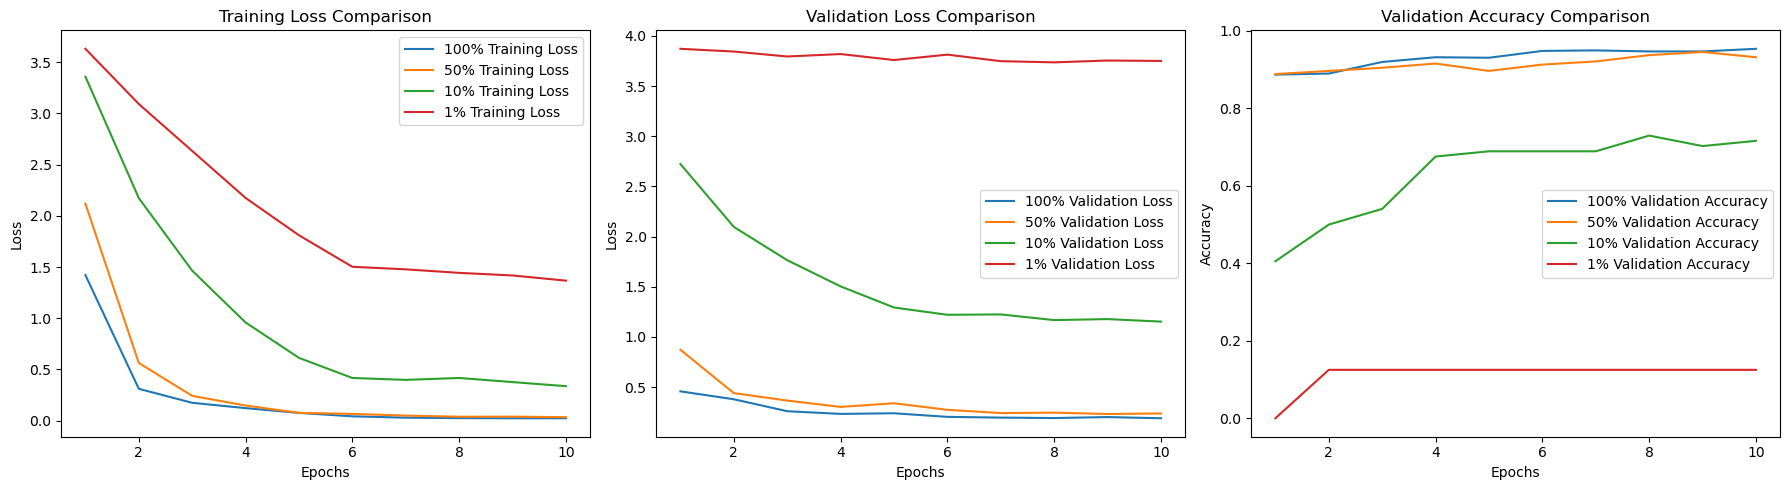

In [11]:
import matplotlib.pyplot as plt

def plot_experiment_results(results):
    epochs = range(1, len(next(iter(results.values()))['training_losses']) + 1)
    
    plt.figure(figsize=(18, 5))
    
    # 训练损失对比
    plt.subplot(1, 3, 1)
    for percent, outcomes in results.items():
        plt.plot(epochs, outcomes['training_losses'], label=f'{percent} Training Loss')
    plt.title('Training Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 验证损失对比
    plt.subplot(1, 3, 2)
    for percent, outcomes in results.items():
        plt.plot(epochs, outcomes['validation_losses'], label=f'{percent} Validation Loss')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 验证准确率对比
    plt.subplot(1, 3, 3)
    for percent, outcomes in results.items():
        plt.plot(epochs, outcomes['validation_accuracies'], label=f'{percent} Validation Accuracy')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()



# 绘制实验结果对比图
plot_experiment_results(experiment_results)

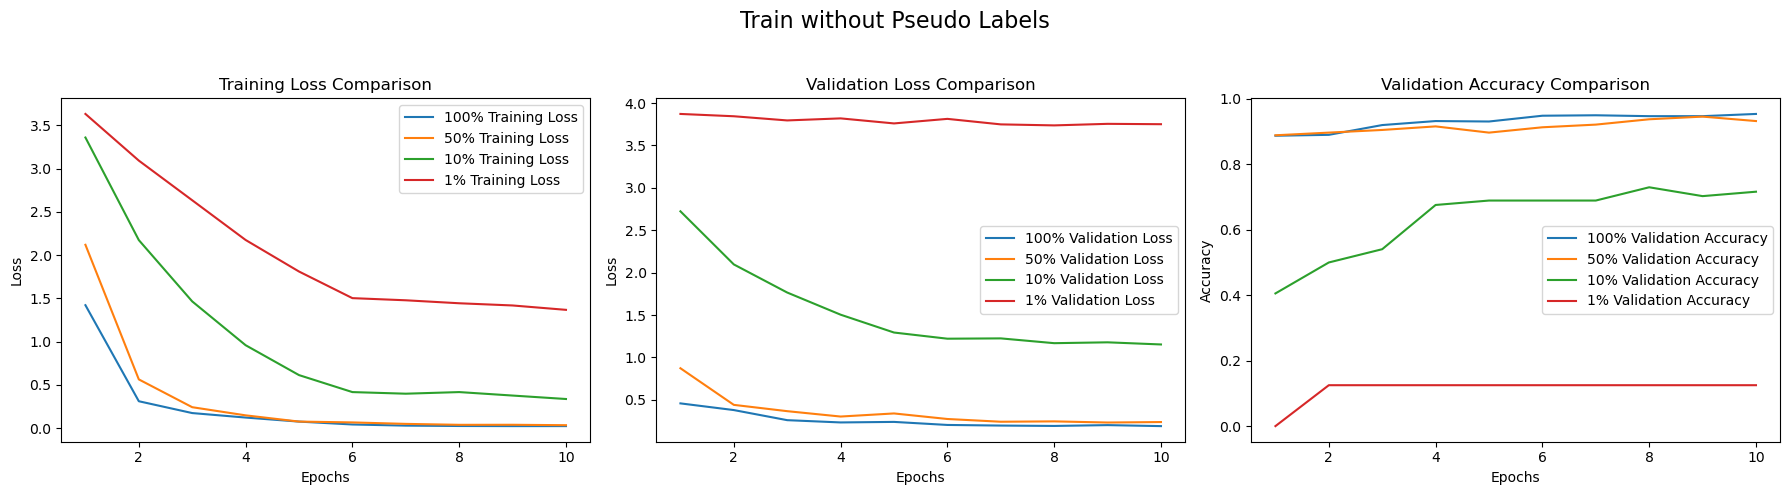

In [12]:
import matplotlib.pyplot as plt

def plot_experiment_results(results):
    epochs = range(1, len(next(iter(results.values()))['training_losses']) + 1)
    
    plt.figure(figsize=(18, 5))
    
    # 训练损失对比
    plt.subplot(1, 3, 1)
    for percent, outcomes in results.items():
        plt.plot(epochs, outcomes['training_losses'], label=f'{percent} Training Loss')
    plt.title('Training Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 验证损失对比
    plt.subplot(1, 3, 2)
    for percent, outcomes in results.items():
        plt.plot(epochs, outcomes['validation_losses'], label=f'{percent} Validation Loss')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 验证准确率对比
    plt.subplot(1, 3, 3)
    for percent, outcomes in results.items():
        plt.plot(epochs, outcomes['validation_accuracies'], label=f'{percent} Validation Accuracy')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # 添加大标题
    plt.suptitle('Train without Pseudo Labels', fontsize=16)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # 调整子图布局以适应大标题
    plt.show()
plot_experiment_results(experiment_results)